<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/ISOTIPO-Color.jpg" title="Title text" width="20%" />

<hr style="height:2px;border:none"/>
<H1 align='center'> Challenge Kaggle </H1>
<H5 align='center'> Predicción Velocidad del viento: EDA </H5>

<H3> INF-395 Redes Neuronales y Deep Learning </H3>
<H3> Autores: Francisco Andrades | Lucas Díaz</H3>

Lenguaje: Python

Temas:

    - Redes Neuronales Recurrentes.
    - Modelos Generativos.
    - Autoencoders.
    - Modelos Especiales.
    
Link Competencia: https://www.kaggle.com/c/prediccin-velocidad-del-viento

Equipo: Bios

Video Explicativo: https://youtu.be/WYjm28I2uMw

<hr style="height:2px;border:none"/>

### Contexto

Queremos predecir la velocidad media del viento a 20 metros de altura en diferentes instantes de tiempo.

### Dataset

El dataset contiene la velocidad media del viento a 20 metros de altura para cada instante de tiempo determinado. El conjunto de entrenamiento contiene 123365 registros cada 10 minutos de la velocidad media del viento desde el 19 de Diciembre de 2012 a las 00:10 hasta el 24 de Abril de 2015 a las 23:50. El conjunto de test consiste en diferentes instantes de tiempo a partir del 26 de Abril de 2015

**La métrica de evaluación para esta competencia es RMSE** 

In [26]:
#librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf

def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

#se cargan los datos de train
path = '../input/prediccin-velocidad-del-viento/'
df_train = pd.read_csv(path+'windspeed-training.csv')
df_train.head()

,Fecha,Velocidad de viento en 20.0 metros [mean]
0,2012-12-19 00:10,12.4
1,2012-12-19 00:20,11.4
2,2012-12-19 00:30,11.8
3,2012-12-19 00:40,11.6
4,2012-12-19 00:50,11.0


In [27]:
# se transforman los datos a formato datetime
df_train = pd.read_csv(path+'windspeed-training.csv')
df_train['Fecha'] =  pd.to_datetime(df_train['Fecha'])
df_train['year'] = df_train.Fecha.dt.year
df_train['month'] = df_train.Fecha.dt.month
df_train['day'] = df_train.Fecha.dt.day
df_train['hour'] = df_train.Fecha.dt.hour
# tomar la media y std por (mes,hora)
df_pivot = pd.pivot_table(df_train,index = ['month','hour'],values=[df_train.columns[1]],aggfunc=[np.mean,np.std])

In [28]:
# revisamos cantidad e intervalos de datos
print("Cantidad de datos de 2012: ",df_train[df_train.year == 2012].shape[0])
print("Cantidad de datos de 2013: ",df_train[df_train.year == 2013].shape[0])
print("Cantidad de datos de 2014: ",df_train[df_train.year == 2014].shape[0])
print("Cantidad de datos de 2015: ",df_train[df_train.year == 2015].shape[0])

print("\nIntervalo de fechas para 2012: ",df_train[df_train.year == 2012].iloc[[0,-1]].Fecha.values)
print("Intervalo de fechas para 2013: ",df_train[df_train.year == 2013].iloc[[0,-1]].Fecha.values)
print("Intervalo de fechas para 2014: ",df_train[df_train.year == 2014].iloc[[0,-1]].Fecha.values)
print("Intervalo de fechas para 2015: ",df_train[df_train.year == 2015].iloc[[0,-1]].Fecha.values)

Cantidad de datos de 2012:  1871
Cantidad de datos de 2013:  52560
Cantidad de datos de 2014:  52517
Cantidad de datos de 2015:  16416

Intervalo de fechas para 2012:  ['2012-12-19T00:10:00.000000000' '2012-12-31T23:50:00.000000000']
Intervalo de fechas para 2013:  ['2013-01-01T00:00:00.000000000' '2013-12-31T23:50:00.000000000']
Intervalo de fechas para 2014:  ['2014-01-01T00:00:00.000000000' '2014-12-31T23:50:00.000000000']
Intervalo de fechas para 2015:  ['2015-01-01T00:00:00.000000000' '2015-04-24T23:50:00.000000000']


Se puede apreciar que la cantidad de datos del 2012 es despreciable. 

Se tienen los años 2013 y 2014 completos. 

Sobre el año 2015 (año target) sólo se tienen datos hasta 24/04. Como referencia, los datos de test empiezan el 26/04.

<AxesSubplot:xlabel='Velocidad de viento en 20.0 metros [mean]'>

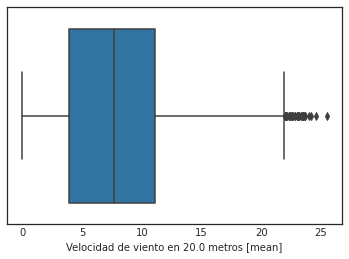

In [29]:
sns.boxplot(x = df_train[df_train.columns[1]])

Hay algunos outliers, pero no severos. Esto es esperable debido a la volatilidad del viento.

La mayoría de los datos están en el intervalo [4,12] aprox.

### Viendo la serie completa a distintas escalas

Cada 10 minutos


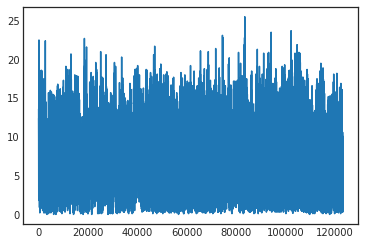

Cada 1 hora


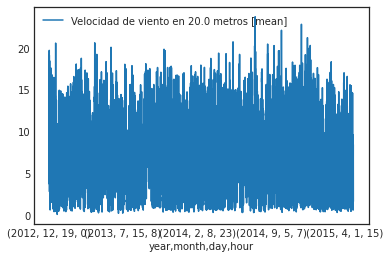

Cada 1 día


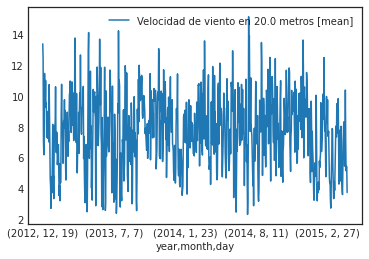

Cada 1 mes


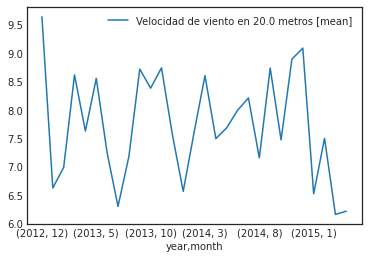

Cada 1 año


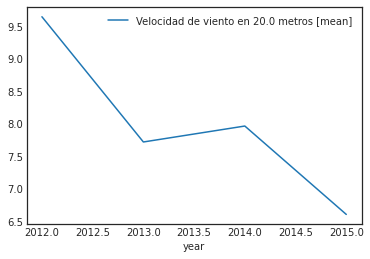

In [31]:
print("Cada 10 minutos")
df_train[df_train.columns[1]].plot()
plt.show()
print("Cada 1 hora")
df_train.pivot_table(index=['year','month','day','hour'],values = df_train.columns[1]).plot()
plt.show()
print("Cada 1 día")
df_train.pivot_table(index=['year','month','day'],values = df_train.columns[1]).plot()
plt.show()
print("Cada 1 mes")
df_train.pivot_table(index=['year','month'],values = df_train.columns[1]).plot()
plt.show()
print("Cada 1 año")
df_train.pivot_table(index=['year'],values = df_train.columns[1]).plot()
plt.show()

### Revisando la velocidad promedio para cada combinación (mes,hora)

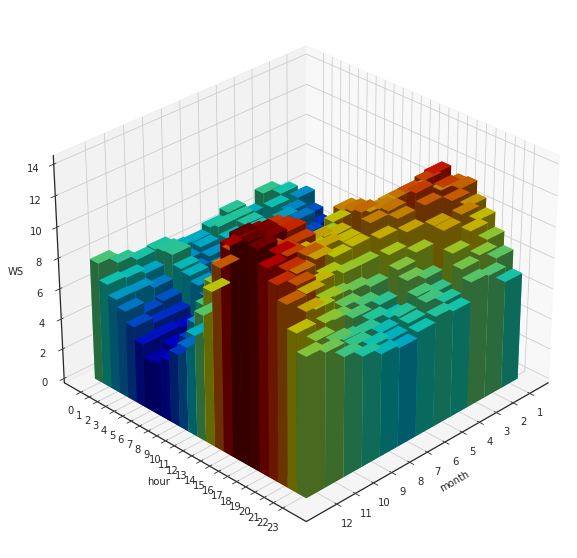

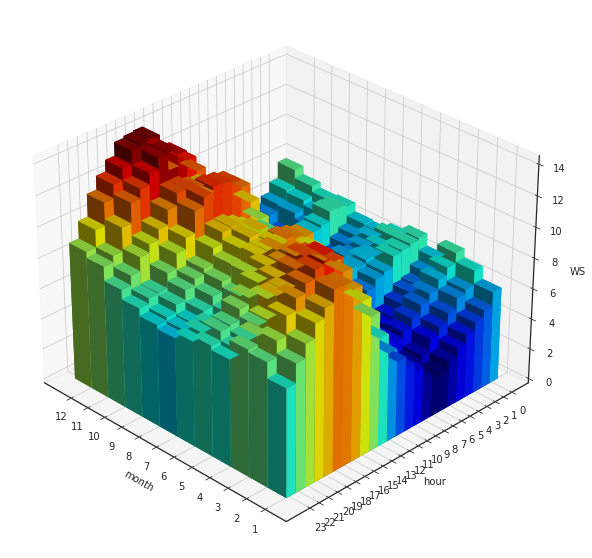

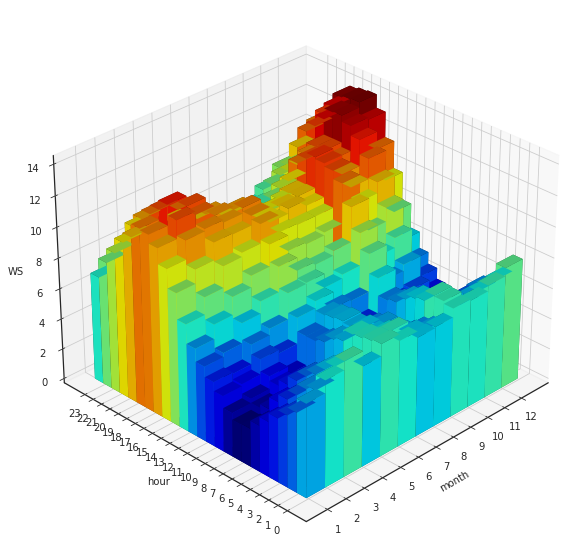

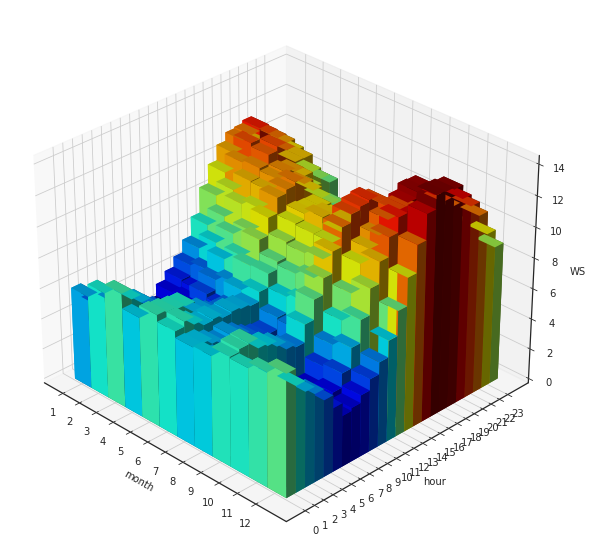

In [32]:
#Conclusión: la hora está muy marcada. mes igual marcado pero no tanto
from mpl_toolkits.mplot3d import axes3d
plt.style.use('seaborn-white')
lista = []
for elem in [1,2,3,4,5,6,7,8,9,10,11,12]:
    #display(df_pivot.loc[(elem,),df_pivot.columns[0]].values)
    lista.append(df_pivot.loc[(elem,),df_pivot.columns[0]].values.reshape(-1,1))
z = np.hstack(lista).ravel()


xlabels = df_pivot.index.get_level_values('month').unique()
ylabels = df_pivot.index.get_level_values('hour').unique()
x = np.arange(xlabels.shape[0])
y = np.arange(ylabels.shape[0])
x_M, y_M = np.meshgrid(x, y, copy=False)
import matplotlib.colors as colors
import matplotlib.cm as cm
for rot in [45,135,225,315]:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Making the intervals in the axes match with their respective entries
    ax.w_xaxis.set_ticks(x + 0.5/2.)
    ax.w_yaxis.set_ticks(y + 0.5/2.)

    # Renaming the ticks as they were before
    ax.w_xaxis.set_ticklabels(xlabels)
    ax.w_yaxis.set_ticklabels(ylabels)

    # Labeling the 3 dimensions
    ax.set_xlabel('month')
    ax.set_ylabel('hour')
    ax.set_zlabel('WS')
    offset = z + np.abs(z.min())
    fracs = offset.astype(float)/offset.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    color_values = cm.jet(norm(fracs.tolist()))

    # Choosing the range of values to be extended in the set colormap
    values = np.linspace(0.2, 1., x_M.ravel().shape[0])

    # Selecting an appropriate colormap
    #colors = plt.cm.Spectral(values)

    ax.bar3d(x_M.ravel(), y_M.ravel(), z*0, dx=1, dy=1, dz=z, color=color_values)
    ax.view_init(azim=rot)
    plt.show()

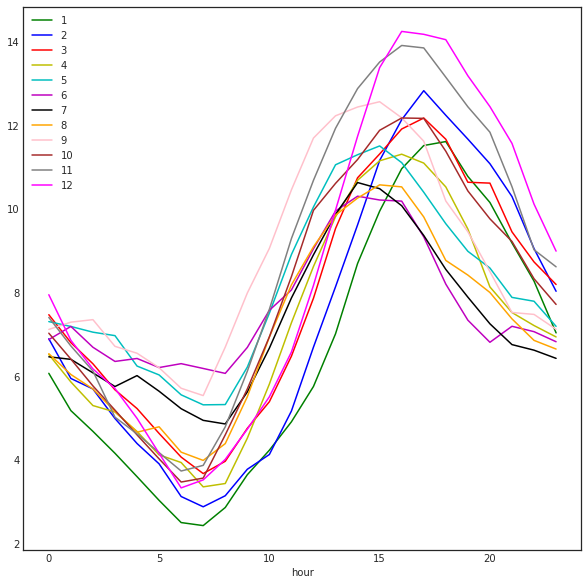

In [33]:
#Se refuerza el analaisis anterior
labels = [1,2,3,4,5,6,7,8,9,10,11,12]
colors = ['g','b','r','y','c','m','k','orange','pink','brown','gray','fuchsia']
for cont,elem in enumerate(labels):
    df_pivot.loc[elem,df_pivot.columns[0]].plot(figsize=(10,10),color=colors[cont])
plt.legend(labels)
plt.show()

**Se puede apreciar que la hora es un factor extremadamente relevante.**

El mes también es relevante, pero en menor medida.


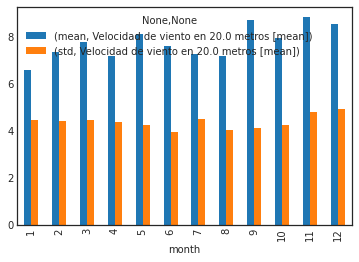

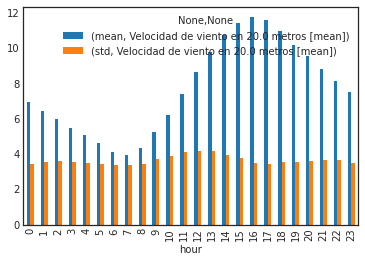

In [8]:
# Revisando (media, std) para meses y para horas por separado.
df_pivot2 = pd.pivot_table(df_train,index = ['year','month','hour'],values=[df_train.columns[1]],aggfunc=np.mean)

df_train.pivot_table(index = 'month',values=df_train.columns[1],aggfunc = [np.mean,np.std]).plot(kind='bar')
plt.show()
df_train.pivot_table(index = 'hour',values=df_train.columns[1],aggfunc = [np.mean,np.std]).plot(kind='bar')
plt.show()


std no cambia mucho para cada caso -> No hay horas o meses en donde la media sea más fiable que en otras 

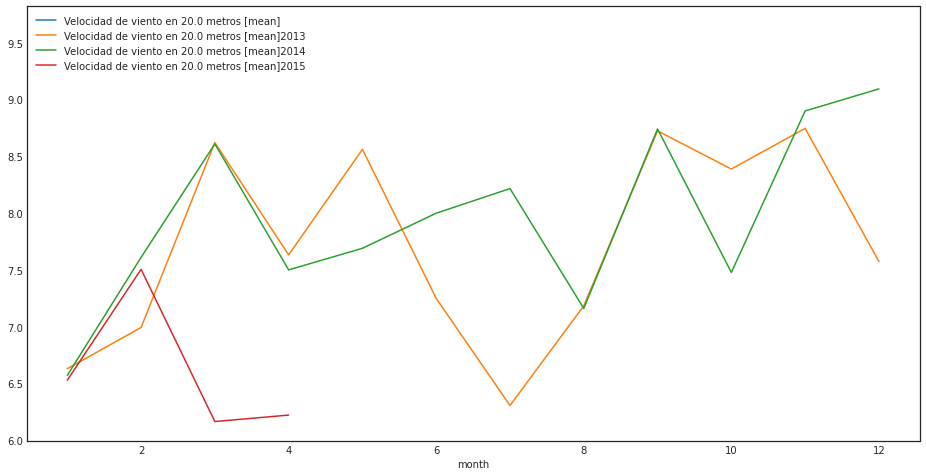

lag mas relacionado: 1, con corr: 0.9642816308657572 


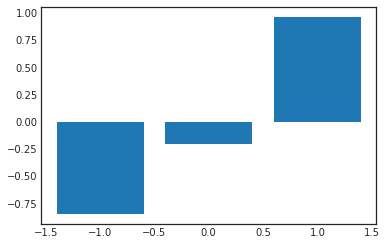

In [34]:
#Viendo tendencia general del año por mes
pivotx = df_train.pivot_table(index=['year','month'],values=df_train.columns[1],aggfunc=np.mean)
tabla_2012 = pivotx.loc[(2012,)]
tabla_2013 = pivotx.loc[(2013,)]
tabla_2014 = pivotx.loc[(2014,)]
tabla_2015 = pivotx.loc[(2015,)]
aux = tabla_2012.join(tabla_2013,how='outer',rsuffix='2013')
aux = aux.join(tabla_2014,how='outer',rsuffix='2014')
aux = aux.join(tabla_2015,how='outer',rsuffix='2015')
aux.plot(figsize=(16,8))
plt.show()

lista = []
for lag in range(-1,2):
    try:
        lista.append(crosscorr(aux[aux.columns[2]],aux[aux.columns[3]],lag))
    except:
        break
plt.bar(range(-1,2),lista)
print("lag mas relacionado: {}, con corr: {} ".format(range(-1,2)[np.argmax(lista)],np.max(lista)))

## Se plantean las preguntas:
    -Tendencia a la baja en el 2015. Se mantiene?
    -Existe un shift en el 2015?


### Sobre posible shift:

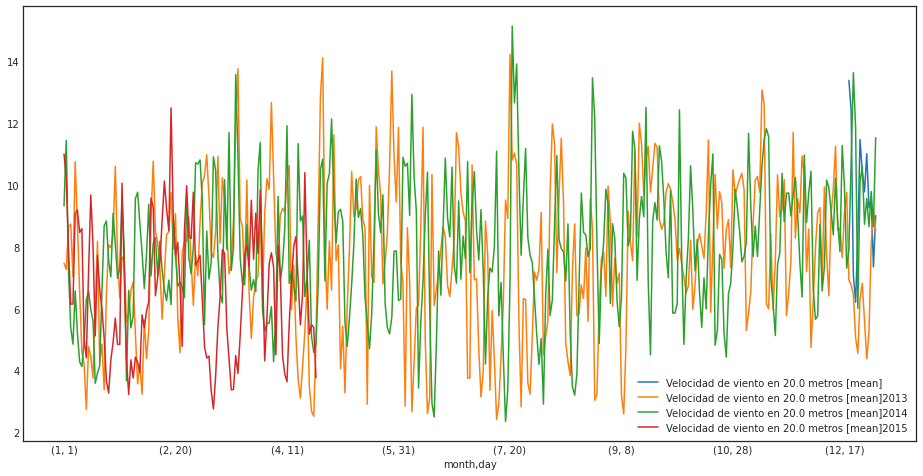

lag mas relacionado: 17, con corr: 0.22744817014289792 


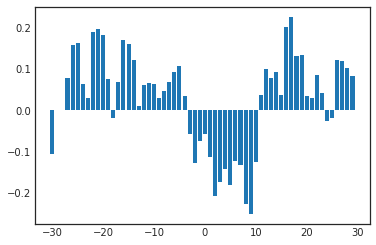

In [18]:
#viendo la serie completa pero mean per day, separando por años
# No se pierde cronología
#conclusión: Buena pinta
pivotx = df_train.pivot_table(index=['year','month','day'],values=df_train.columns[1],aggfunc=np.mean)
tabla_2012 = pivotx.loc[(2012,)]
tabla_2013 = pivotx.loc[(2013,)]
tabla_2014 = pivotx.loc[(2014,)]
tabla_2015 = pivotx.loc[(2015,)]
aux = tabla_2012.join(tabla_2013,how='outer',rsuffix='2013')
aux = aux.join(tabla_2014,how='outer',rsuffix='2014')
aux = aux.join(tabla_2015,how='outer',rsuffix='2015')
aux.plot(figsize=(16,8))
plt.show()

lista = []
for lag in range(-30,30):
    try:
        lista.append(crosscorr(aux[aux.columns[2]],aux[aux.columns[3]],lag))
    except:
        break
plt.bar(range(-len(lista)//2,len(lista)//2),lista)
print("lag mas relacionado: {}, con corr: {} ".format(range(-len(lista)//2,len(lista)//2)[np.argmax(lista)],np.max(lista)))

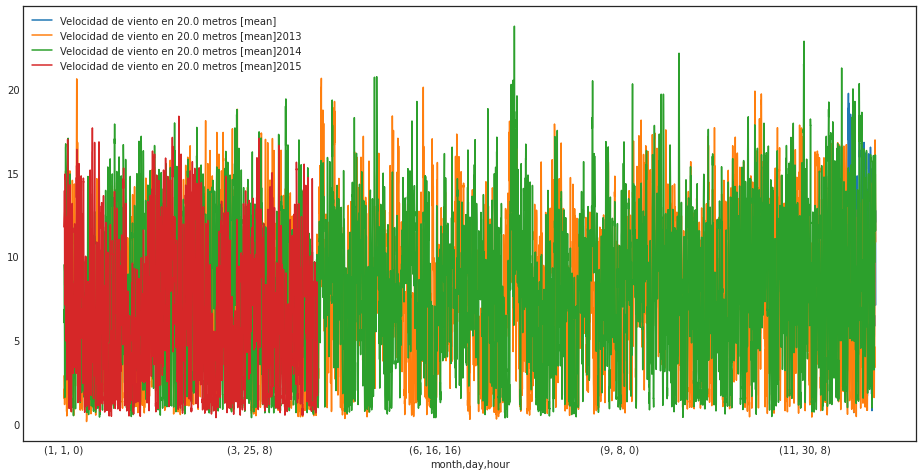

lag mas relacionado: 408, con corr: 0.5477448403077989 


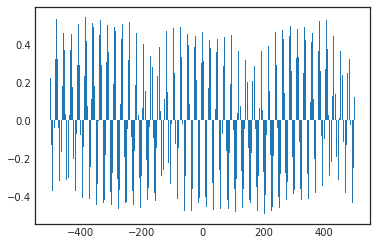

In [19]:
#viendo la serie completa pero mean per day per hour, separando por años
# No se pierde cronología
#conclusión: Buena pinta
pivotx = df_train.pivot_table(index=['year','month','day','hour'],values=df_train.columns[1],aggfunc=np.mean)
tabla_2012 = pivotx.loc[(2012,)]
tabla_2013 = pivotx.loc[(2013,)]
tabla_2014 = pivotx.loc[(2014,)]
tabla_2015 = pivotx.loc[(2015,)]
aux = tabla_2012.join(tabla_2013,how='outer',rsuffix='2013')
aux = aux.join(tabla_2014,how='outer',rsuffix='2014')
aux = aux.join(tabla_2015,how='outer',rsuffix='2015')
aux.plot(figsize=(16,8))
plt.show()
#largo = aux[aux.columns[1]].shape[0]
#plt.plot(range(-int(largo/2) ,largo-int(largo/2)),statsmodels.tsa.stattools.ccf(aux[aux.columns[1]],aux[aux.columns[2]]))
#plt.show()
lista = []
for lag in range(-500,500):
    try:
        lista.append(crosscorr(aux[aux.columns[2]],aux[aux.columns[3]],lag))
    except:
        break
plt.bar(range(-len(lista)//2,len(lista)//2),lista)
print("lag mas relacionado: {}, con corr: {} ".format(range(-len(lista)//2,len(lista)//2)[np.argmax(lista)],np.max(lista)))

In [37]:
print("lag mas relacionado: {} días".format(408/24))

lag mas relacionado: 17.0 días


**Pareciera haber un shift de 17 dias**

### Sobre tendencia a la baja en 2015



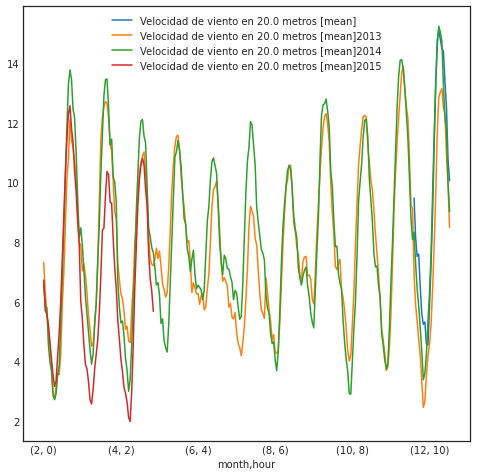

lag mas relacionado: 0, con corr: 0.9251862920697065 


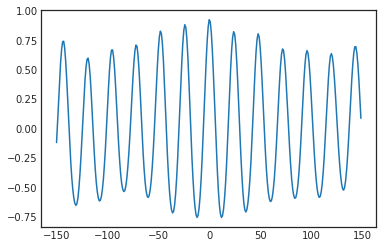

In [21]:
#viendo las series separadas por año, promediando para cada (mes,hour)
# Se pierde cronologia
# Buena pinta
tabla_2012 = df_pivot2.loc[(2012,)]
tabla_2013 = df_pivot2.loc[(2013,)]
tabla_2014 = df_pivot2.loc[(2014,)]
tabla_2015 = df_pivot2.loc[(2015,)]
aux = tabla_2012.join(tabla_2013,how='outer',rsuffix='2013')
aux = aux.join(tabla_2014,how='outer',rsuffix='2014')
aux = aux.join(tabla_2015,how='outer',rsuffix='2015')
aux.drop((1,),inplace=True)
aux.plot(figsize=(8,8))
plt.show()
lista = []

for lag in range(-150,150):
    try:
        lista.append(crosscorr(aux[aux.columns[1]],aux[aux.columns[2]],lag))
    except:
        break
plt.plot(range(-len(lista)//2,len(lista)//2),lista)
print("lag mas relacionado: {}, con corr: {} ".format(range(-len(lista)//2,len(lista)//2)[np.argmax(lista)],np.max(lista)))

In [22]:
#correlacion lineal fuerte entre las series anteriores
# esto considera correlación entre las variables con la variable equivalente de años anteriores
# es decir, (mes,hour)_2015 -> (mismo_mes,mismo_hour)_2014 ...
aux.corr()

,Velocidad de viento en 20.0 metros [mean],Velocidad de viento en 20.0 metros [mean]2013,Velocidad de viento en 20.0 metros [mean]2014,Velocidad de viento en 20.0 metros [mean]2015
Velocidad de viento en 20.0 metros [mean],1.000000,0.975112,0.979731,NaN
Velocidad de viento en 20.0 metros [mean]2013,0.975112,1.000000,0.925186,0.860667
Velocidad de viento en 20.0 metros [mean]2014,0.979731,0.925186,1.000000,0.935230
Velocidad de viento en 20.0 metros [mean]2015,NaN,0.860667,0.935230,1.000000


In [23]:
#Regresión lineal para concluir sobre tendencia a la baja
train_data = aux.loc[aux[aux.columns[3]].notna(),[aux.columns[1],aux.columns[2],aux.columns[3]]]
from sklearn.linear_model import LinearRegression
train_data.columns = range(len(train_data.columns))
y_train = train_data.pop(train_data.columns[2])
clf = LinearRegression().fit(train_data,y_train)
to_predict =  aux.loc[aux[aux.columns[3]].isna(),[aux.columns[1],aux.columns[2]]]
preds = clf.predict(to_predict)
preds = pd.Series(preds,index=to_predict.index)

<AxesSubplot:xlabel='month,hour'>

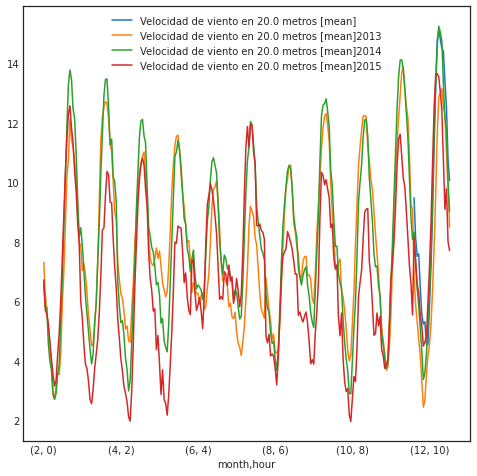

In [24]:
aux[aux.columns[3]].fillna(preds,inplace=True)
final = aux[aux.columns[3]]
aux.plot(figsize=(8,8))

## Sobre tendencia a la baja en 2015.
Se probó en el leaderboard público:

    - mean (month,hour) usando info 2014 y 2013 para predecir 2015 (No considera tendencia a la baja)
    
    -regresión lineal sobre datos (month,hour) usando como target hasta abril. (Considera tendencia a la baja)
   
#### Predecir sólo la media ha dado mejores resultados siempre. Esto sugiere que el año se regulariza. 

### Viendo tendencia de cada mes (en días)

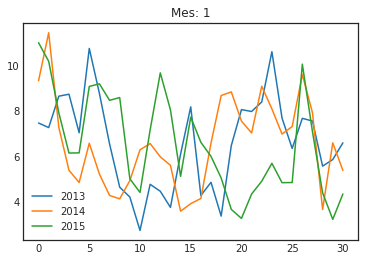

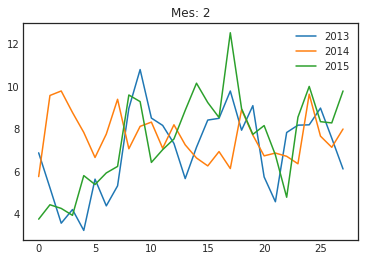

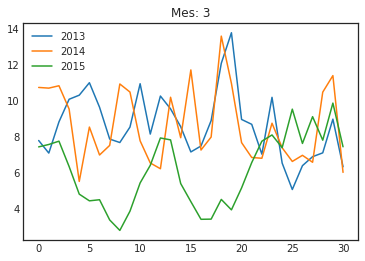

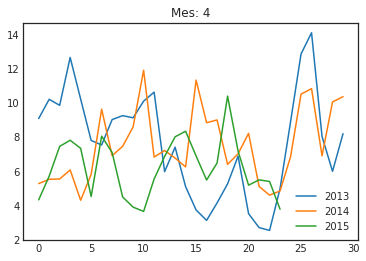

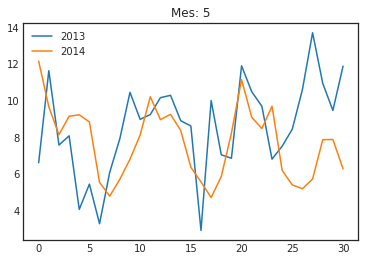

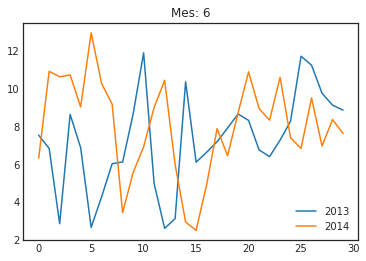

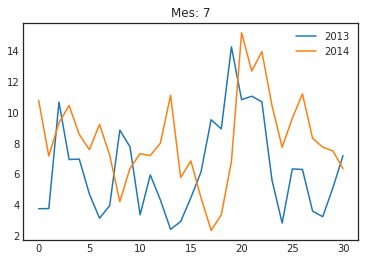

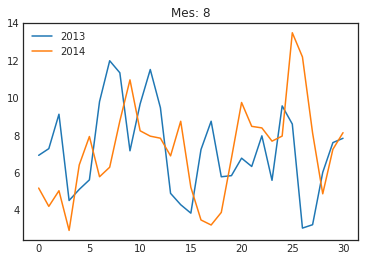

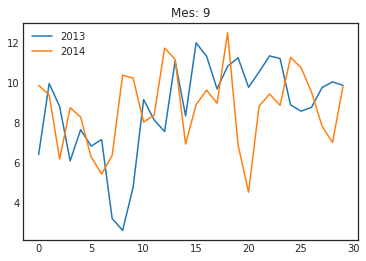

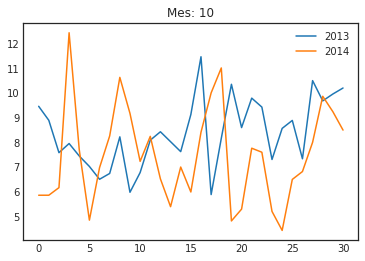

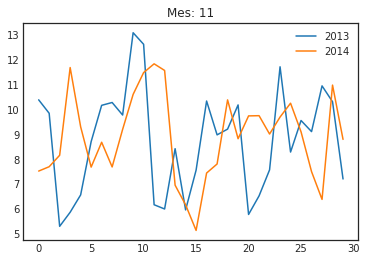

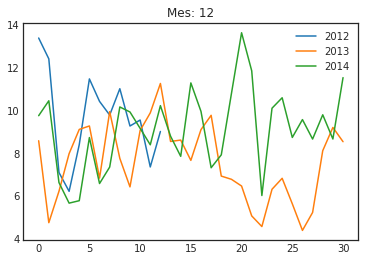

In [25]:
#viendo tendencia de cada mes, separados por año
pivotx = df_train.pivot_table(index=['year','month','day'],values=df_train.columns[1],aggfunc=np.mean)
arr = pivotx.pivot_table(index=['year','month'],aggfunc=list)
new = arr.pivot_table(index=['month'],aggfunc=list)
for elem in labels:
    for lista in new.loc[elem].values[0]:
        plt.plot(lista)
    plt.title("Mes: "+ str(elem))
    plt.legend(['2013','2014','2015'])
    if elem ==12:
        plt.legend(['2012','2013','2014'])
    plt.show()

Se ven patrones difusos.